In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data=f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines=lines[1:]
print(header)
print(len(header),'num features')
print(len(lines),'number of data')
print(lines[0])
print(type(lines[0]))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15 num features
420551 number of data
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
<class 'str'>


In [3]:
float_data = np.zeros((len(lines),len(header)-1))
print(float_data.shape)
#we have 420551 samples and 14 features

(420551, 14)


In [4]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] #return array of strings
    float_data[i,:] = values
    
print(float_data.shape)

(420551, 14)


In [5]:
print(float_data[0])

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


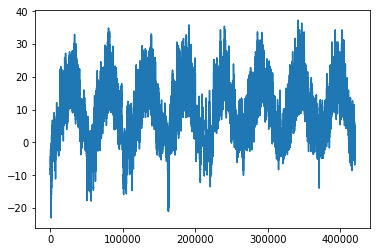

In [6]:
temp = float_data[:,1]
plt.plot(range(len(temp)),temp)

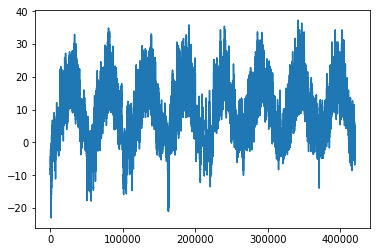

In [7]:
temp = float_data[:,1]
plt.plot(temp)  #same thing as before but with less code

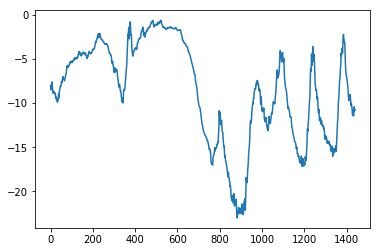

In [8]:
plt.plot(range(1440),temp[:1440])   #10 days - iterval of 10 minutes

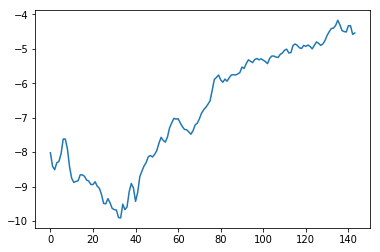

In [9]:
plt.plot(range(144),temp[:144])   #1 day

In [10]:
#Now we have to normalize the data
mean = float_data[:200000].mean(axis=0)
print(mean.shape)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /=std

(14,)


In [41]:
lookback = 720 #5 days in the past  --> input
steps = 6 #one sample per hour
delay = 144 # target 24h in the future

#we take a sample and we go back to the past 5 days and
#than we predict 24 hours from that timestamp

def generator(
    data,
    lookback, delay,
    min_index, max_index,
    shuffle=False,   
    batch_size=128,
    step=6):

    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback 
    while True:

        if shuffle:
            rows = np.random.randint(
                min_index + lookback,
                max_index,
                batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

In [42]:
next(generator(float_data,lookback,delay,0,200000))[0].shape  #input shape

(128, 120, 14)

In [43]:
next(generator(float_data,lookback,delay,0,200000))[1].shape  #output shape

(128,)

In [57]:
batch_size=128
#we need 3 generator for train, validation and testing
train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True, #we shuffle just the training to reduce the bias on the order of the samples
    step=steps,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=steps,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=steps,
    batch_size=batch_size
)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [59]:
#how many samples we are using for validation
val_steps*batch_size

12707712

In [58]:
from keras import models,layers,optimizers
model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // steps, float_data.shape[-1]))) 
#shape 120,14 (as 2nd and 3rd dimension of generator[0]
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizers.RMSprop(),loss='mse',metrics=['mae'])

history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,
                             validation_steps=val_steps//100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 1680)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                53792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 12s 24ms/step - loss: 1.1820 - mean_absolute_error: 0.7134 - val_loss: 0.2104 - val_mean_absolute_error: 0.3664
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2585 - mean_absolute_error: 0.3895 - val_loss: 0.1561 - val_mean_absolute_error: 0.3114
Epoch 3/20
500/500 [==============================] - 12s 23ms/step - 

In [60]:
model = models.Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizers.RMSprop(),loss='mse',metrics=['mae'])

history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,
                             validation_steps=val_steps//100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 69s 138ms/step - loss: 0.1580 - mean_absolute_error: 0.3056 - val_loss: 0.1265 - val_mean_absolute_error: 0.2772
Epoch 2/20
500/500 [==============================] - 69s 139ms/step - loss: 0.1301 - mean_absolute_error: 0.2821 - val_loss: 0.1153 - val_mean_absolute_error: 0.2640
Epoch 3/20
500/500 [==============================] - 68s 137ms/step -